In [12]:
from src.models import TemporalPC #This is the model I'm trying to implement. 
# What I'm hoping for it to do is that I can show it an image sequence and it will predict the next image.
# For now I'm just trying to show it the same image a number of time, and hoping that it will predict that the next image is just the same as the previous ones. 

In [13]:
from torchvision import transforms, io
from torch import mean, stack, Size, std, cuda
from PIL import Image

In [14]:
bar_img = Image.open("/Users/janthiel/Documents/white_bar.jpg") # This is the input, 255 x 255px 

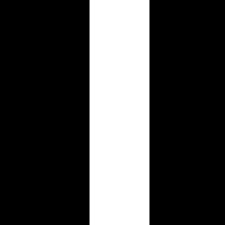

In [15]:
bar_img 

In [16]:
convert_tensor = transforms.ToTensor() 

In [33]:
tensor_1 = convert_tensor(bar_img) # converting image to tensor 
tensor_1 # I think it's just zeros because it's black at the edges because the mean is still positive

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [28]:
flat = tensor_1.view(151875) # flattening tensor to vector of dimension 255*255*3 (3 RGB values)
flat

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [29]:
mean(flat)

tensor(0.2663)

In [26]:
transform = transforms.ToPILImage() # This will later transform the output back into an image
transform

ToPILImage()

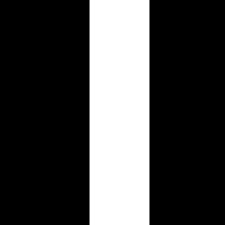

In [35]:
transform(flat.view(3, 225, 225)) # This is the input first transformed to tensor then flattened then unflattend and transformed back to image.

In [20]:
model = TemporalPC(151875,1000,151875) # Initialising the model, with control size = output size = 151875, and hidden layer size = 1000

In [21]:
bsz = 1  # Initialising the hidden layer so that prev_z is defined before call inference 
prev_z = model.init_hidden(bsz)

In [30]:
l = []
for i in range(10):    # Calling inference 10 times, after every time assigning the current hidden state (model.z) to the previous hidden state (prev_z). In my head this means I'm showing it the same picture 10 times.
    model.inference(inf_iters=1, inf_lr=0.1, x=flat, u=flat, prev_z=prev_z, update_x=False)
    prev_z = model.z
    l.append(model.update_grads(x=flat, u=flat, prev_z=prev_z)) # This shows the energy for every iteration which from my understanding is a measure of the error. It doesn't decrease with more iterations
l

[tensor(65839.0547, grad_fn=<AddBackward0>),
 tensor(66110.8906, grad_fn=<AddBackward0>),
 tensor(65171.5352, grad_fn=<AddBackward0>),
 tensor(66197.4922, grad_fn=<AddBackward0>),
 tensor(66342.7344, grad_fn=<AddBackward0>),
 tensor(65967.5312, grad_fn=<AddBackward0>),
 tensor(66261.1094, grad_fn=<AddBackward0>),
 tensor(65895.6953, grad_fn=<AddBackward0>),
 tensor(65334.8516, grad_fn=<AddBackward0>),
 tensor(66272.2031, grad_fn=<AddBackward0>)]

In [32]:
pred_z, pred_x = model.forward(prev_z = prev_z, u = flat) # Calling the forward function 
pred_x

tensor([[-0.3583, -0.1423, -0.0351,  ...,  0.2825,  0.2399, -0.0460]],
       grad_fn=<MmBackward0>)

In [31]:
output_image = pred_x.view(3, 225, 225) # Transforming the output vector into a tensor
output_image

tensor([[[-0.2280, -0.2676, -0.2270,  ...,  0.0037, -0.0829, -0.1077],
         [ 0.0775, -0.2111, -0.1043,  ...,  0.2376, -0.0205,  0.4868],
         [ 0.3347,  0.1474, -0.2359,  ...,  0.1699, -0.1303,  0.1020],
         ...,
         [ 0.3291,  0.6371,  0.1550,  ...,  0.3938, -0.0482, -0.1565],
         [-0.0813,  0.2562, -0.1139,  ...,  0.4720,  0.5055,  0.3556],
         [-0.0990, -0.0856,  0.2202,  ..., -0.0784,  0.1249,  0.2384]],

        [[ 0.5321, -0.0102, -0.0543,  ..., -0.2265,  0.4754, -0.1190],
         [-0.0788,  0.3155,  0.1646,  ..., -0.0393,  0.1472, -0.0640],
         [-0.0904, -0.2534,  0.0181,  ...,  0.0402,  0.4983, -0.1000],
         ...,
         [ 0.2832, -0.1702, -0.3666,  ...,  0.2154, -0.0611, -0.1059],
         [ 0.5275,  0.1633,  0.2495,  ...,  0.2475, -0.0432,  0.1347],
         [-0.4047,  0.1250,  0.4149,  ..., -0.0646,  0.3686, -0.1594]],

        [[ 0.3820, -0.2530,  0.0629,  ...,  0.5143, -0.4688, -0.3264],
         [-0.1166, -0.1941, -0.1824,  ..., -0

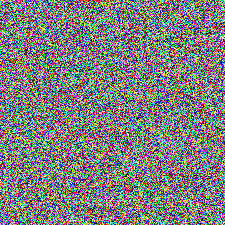

In [25]:
transform(output_image) # transforming the tensor into an image

In [ ]:
# output is just noise. I've tried different learning rates, different dimensions for the hidden layer, and higher number of iterations but the error does not get smaller.
# Anyway, thanks for having a look! 